In [2]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

from argparse import Namespace

from sklearn import metrics
from sklearn.model_selection import train_test_split

from datasetPreProcessing import LoadDatasetByName
from models import *
from methods import *

import functools
import numpy as np
import pandas as pd
import torch
import scipy
#import os
import time

import pyod

from pyod.models.feature_bagging import FeatureBagging
from pyod.models.suod import SUOD
from pyod.models.xgbod import XGBOD

from pyod.models.alad import ALAD
from pyod.models.abod import ABOD
from pyod.models.lof import LOF
from pyod.models.cblof import CBLOF
from pyod.models.cof import COF

from pyod.models.hbos import HBOS
from pyod.models.copod import COPOD
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.loda import LODA

from pyod.models.mcd import MCD
from pyod.models.pca import PCA
from pyod.models.ocsvm import OCSVM
from pyod.models.deep_svdd import DeepSVDD
from pyod.models.kpca import KPCA

# distribution based OD
from pyod.models.kde import KDE

from pyod.models.anogan import AnoGAN

from pyod.models.auto_encoder import AutoEncoder as pyodAE
from pyod.models.vae import VAE as pyodVAE

# supervised OD
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import HistGradientBoostingClassifier


In [3]:
# import data
#DATASET = 'ECU_IoHT_data'
#DATASET = 'TON_IoT_data'
DATASET = 'TON_IoT_full_data'
#DATASET = 'creditcard_data'
#DATASET = 'network_data'
hardClassify = False
#DATASET = 'iiot_data'
unbalanced_data = False
CONTAMINATION = 0.001
"""___________________Hyper Parameters________________________"""
repetitions = 1

"""___________________________________________________________"""
# Load Dataset
raw_data, anomalous_raw, features, categorical_data_index = LoadDatasetByName(DATASET)
print(raw_data.shape, anomalous_raw.shape)
# Pre-process data
trim_data = False 
filter_corrcoef = True
normalize_data = True
normalization_scheme = "standard_scaling"
remove_noise = False 
noise_threshold = 5
return_dict = {}
SPLIT = [0.9, 0.05, 0.05]
train_data, validation_data, test_data, anomalous_data = preProcessData_OneClass(raw_data, anomalous_raw, trim=trim_data, split=SPLIT, trim_threshold=0.98, normalize=normalize_data, normalization_scheme=normalization_scheme,
            filterLinearDependencies=filter_corrcoef, filter_threshold=0.98, removeNoise=remove_noise, noise_threshold=noise_threshold, return_dict=return_dict, discretize=False, categorical_data_index=categorical_data_index)
print(anomalous_data.shape)
# 
specificity_list, recall_list = [], []
""" X = np.concatenate((raw_data, anomalous_raw), axis=0)
Y = np.concatenate((np.zeros(raw_data.shape[0]), np.ones(anomalous_raw.shape[0])), axis=0)
print(X.shape, Y.shape)
# train test split
#X_train, X_test = train_test_split(X, test_size=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle=True) """

(300000, 16) (161043, 16)
float64
Train data shape after trim:  (270000, 51)
Train data shape after filter corrcoef:  (270000, 49)
Normalization scheme:  standard_scaling
Train data shape after normalize:  (270000, 49)
(161043, 49)


' X = np.concatenate((raw_data, anomalous_raw), axis=0)\nY = np.concatenate((np.zeros(raw_data.shape[0]), np.ones(anomalous_raw.shape[0])), axis=0)\nprint(X.shape, Y.shape)\n# train test split\n#X_train, X_test = train_test_split(X, test_size=0.1)\nX_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle=True) '

In [6]:
# list of OD models training on data with both normal data and anomalies
unsupervised_ODs = []
RandomForest = RandomForestClassifier(class_weight='balanced')
HistGradientBoosting = HistGradientBoostingClassifier(class_weight='balanced')
params_AE = {
    "contamination":CONTAMINATION, "output_activation":'relu', "dropout_rate":0., "l2_regularizer":0e-7, "preprocessing":False,'hidden_neurons':[64, 16, 16, 16, 16, 64],
}

supervised_ODs = [
                    # distribution based algorithms
                    (RandomForest, 'RandomForest'),
                    (HistGradientBoosting, 'HistGradientBoosting'),
                    #(ABOD(contamination=0.1, n_neighbors=5), 'ABOD'),   
]
model_list = [
                        #pyodAE(**params_AE),
                        HBOS(contamination=CONTAMINATION),
                        #COPOD(contamination=CONTAMINATION),
                        #LOF(contamination=CONTAMINATION),
                        #KNN(contamination=CONTAMINATION),
                        #
                        #IForest(contamination=CONTAMINATION),
                        
                        # reconstruction/projection based algorithms
                        #PCA(contamination=CONTAMINATION),
                        #DeepSVDD(contamination=CONTAMINATION),
                        #MCD(contamination=CONTAMINATION),
]
# list of OD models training on data with only normal data
semi_supervised_ODs = [
                        # distribution based algorithms
                        (HBOS(contamination=CONTAMINATION), 'HBOS'),
                        (COPOD(contamination=CONTAMINATION), 'COPOD'),
                        #(ABOD(contamination=0.1, n_neighbors=5), 'ABOD'),
                        #(ALAD(contamination=CONTAMINATION), 'ALAD'), 
                        # proximity based algorithms
                        (LOF(contamination=CONTAMINATION), 'LOF'),
                        (KNN(contamination=CONTAMINATION, n_neighbors=5, method='median'), 'KNN'),
                        #(CBLOF(), 'CBLOF'),
                        #(COF(), 'COF'),
                        #
                        (IForest(contamination=CONTAMINATION), 'IForest'),
                        
                        # reconstruction/projection based algorithms
                        (PCA(contamination=CONTAMINATION), 'PCA'),
                        #(MCD(contamination=CONTAMINATION), 'MCD'),
                        (DeepSVDD(contamination=CONTAMINATION), 'DSVDD'),
                        #(OCSVM(contamination=CONTAMINATION), 'One-Class-SVM'),
                        #(KPCA(contamination=CONTAMINATION), 'KPCA'),
                        #(AnoGAN(contamination=CONTAMINATION), 'AnoGAN'),
                        #(pyodAE(contamination=CONTAMINATION,hidden_neurons=[128, 64, 4, 4, 64, 128], output_activation='relu', dropout_rate=0., l2_regularizer=0e-7, preprocessing=False), 'pyodAE'),
                        #(pyodVAE(contamination=CONTAMINATION), 'VAE'),
                    ]

""" semi_supervised_ODs = [
                        #(pyodAE(contamination=CONTAMINATION,hidden_neurons=[128, 64, 4, 4, 64, 128], output_activation='relu', dropout_rate=0., l2_regularizer=0e-7, preprocessing=False), 'pyodAE'),
                        #(FeatureBagging(base_estimator=pyodAE(), n_estimators=2, contamination=CONTAMINATION, max_features=1.0, combination='max',estimator_params=params_AE), 'FeatureBagging'),
                        #(FeatureBagging(base_estimator=pyodVAE(contamination=0.01), n_estimators=2, contamination=0.1, max_features=1.0, combination='average',estimator_params={'encoder_neurons':[128, 64, 4],'decoder_neurons':[4, 64, 128],}), 'FeatureBagging'),
                        (FeatureBagging(base_estimator=DeepSVDD(contamination=0.05), n_estimators=5, contamination=0.1, max_features=1.0, combination='max'), 'FeatureBagging'),
                        #(SUOD(base_estimators=model_list), 'SUOD'),
                        #(XGBOD(estimator_list=model_list), 'XGBOD'),
                    ] """

" semi_supervised_ODs = [\n                        #(pyodAE(contamination=CONTAMINATION,hidden_neurons=[128, 64, 4, 4, 64, 128], output_activation='relu', dropout_rate=0., l2_regularizer=0e-7, preprocessing=False), 'pyodAE'),\n                        #(FeatureBagging(base_estimator=pyodAE(), n_estimators=2, contamination=CONTAMINATION, max_features=1.0, combination='max',estimator_params=params_AE), 'FeatureBagging'),\n                        #(FeatureBagging(base_estimator=pyodVAE(contamination=0.01), n_estimators=2, contamination=0.1, max_features=1.0, combination='average',estimator_params={'encoder_neurons':[128, 64, 4],'decoder_neurons':[4, 64, 128],}), 'FeatureBagging'),\n                        (FeatureBagging(base_estimator=DeepSVDD(contamination=0.05), n_estimators=5, contamination=0.1, max_features=1.0, combination='max'), 'FeatureBagging'),\n                        #(SUOD(base_estimators=model_list), 'SUOD'),\n                        #(XGBOD(estimator_list=model_list), 'XGBO

In [7]:
# pipeline
pr_dict, roc_dict, mcc_dict = {}, {}, {} # dictionaries of all models' performances to plot
train_time_dict, inference_time_dict = {}, {} # dictionaries of all models' CPU time costs
spec_sens_dict = {}

# train and test data
if unbalanced_data:
    X_train, y_train = train_data, np.zeros(train_data.shape[0])
    X_test = np.concatenate((validation_data, test_data, anomalous_data), axis=0)
    y_test = np.concatenate((np.zeros(validation_data.shape[0]+test_data.shape[0]), np.ones(anomalous_data.shape[0])), axis=0)
else: # if data is balanced
    X = np.concatenate((train_data, validation_data, test_data, anomalous_data), axis=0)
    Y = np.concatenate((np.zeros(raw_data.shape[0]), np.ones(anomalous_data.shape[0])), axis=0)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle=True) 

ODs = supervised_ODs if hardClassify else semi_supervised_ODs

for clf, clf_name in ODs: # loop over all algorithms
    # create prediction (probability) list to compute average upon
    predictions=[]
    
    train_time, inference_time = 0, 0
    for _ in range(repetitions): # r repetitions
        curr_time = time.time() # record train and test CPU time cost
        clf.fit(X_train, y_train) # fit
        train_time += time.time()-curr_time
        
        # test
        curr_time = time.time()
        if hardClassify:
            #y_pred = clf.predict(X_test)
            #y_pred = clf.predict_proba(X_test)
            #y_pred = y_pred[:,-1]
            y_pred = clf.decision_function(X_test)
        else:
            #y_pred = clf.decision_function(X_test)
            print(X_test.shape)
            y_pred = clf.predict_proba(X_test)
            y_pred = y_pred[:,-1]
        #y_pred = np.nan_to_num(y_pred, nan=1e30)
        inference_time += time.time()-curr_time
        predictions.append(y_pred)
    
    # show average time consumption
    train_time, inference_time = train_time/repetitions, inference_time/repetitions
    print("Train time of {}: {:.4f} seconds.".format(clf_name, train_time))
    print("Inference time of {}: {:.4f} seconds.".format(clf_name, inference_time))
    # compute average predictions
    y_pred_average = functools.reduce(lambda a, b: a+b, predictions) / repetitions
    
    precision, recall, _ = metrics.precision_recall_curve(y_true=y_test, probas_pred=y_pred_average)
    fpr, tpr, thresholds = metrics.roc_curve(y_true=y_test, y_score=y_pred_average)
    fpr, tpr, thresholds = fpr[1:-1], tpr[1:-1], thresholds[1:-1]
    #thresholds = (thresholds - thresholds.min())/(thresholds.max() - thresholds.min())   # scale thresholds to (0, 1)
    mcc = MCC(specificity=1-fpr, sensitivity=tpr)
    if hardClassify:
        specificity, sensitivity = metrics.recall_score(y_true=y_test, y_pred=y_pred_average, pos_label=0), metrics.recall_score(y_true=y_test, y_pred=y_pred_average)
        spec_sens_dict[clf_name] = (specificity, sensitivity)
        
    pr_dict[clf_name] = (recall, precision)
    roc_dict[clf_name] = (fpr, tpr)
    mcc_dict[clf_name] = (thresholds, mcc)
    train_time_dict[clf_name] = train_time
    inference_time_dict[clf_name] = inference_time



(46105, 49)
Train time of HBOS: 2.7712 seconds.
Inference time of HBOS: 0.0471 seconds.
(46105, 49)
Train time of COPOD: 4.5526 seconds.
Inference time of COPOD: 4.5279 seconds.
(46105, 49)
Train time of LOF: 136.8659 seconds.
Inference time of LOF: 15.1105 seconds.
(46105, 49)
Train time of KNN: 137.3910 seconds.
Inference time of KNN: 931.8523 seconds.
(46105, 49)
Train time of IForest: 12.7959 seconds.
Inference time of IForest: 0.8102 seconds.
(46105, 49)
Train time of PCA: 1.8175 seconds.
Inference time of PCA: 0.0423 seconds.
12967/12967 [==============================] - 4s 316us/step
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 49)]              0         
                                                                 
 dense_3 (Dense)             (None, 64)                3136      
                                                      

In [ ]:
""" pr_dict.pop('SAE')
roc_dict.pop('SAE')
mcc_dict.pop('SAE')
train_time_dict.pop('SAE')
inference_time_dict.pop('SAE')
1 """

" pr_dict.pop('SAE')\nroc_dict.pop('SAE')\nmcc_dict.pop('SAE')\ntrain_time_dict.pop('SAE')\ninference_time_dict.pop('SAE')\n1 "

In [12]:
# import trained AE model and evaluate
from models import AutoEncoder
from models import SVAE

if True:
    #model = SVAE(num_feature=X_test.shape[-1], latent_dim=8, hidden_dim=16, activation="leaky_relu")
    model = AutoEncoder(num_feature=X_test.shape[-1], latent_dim=8, hidden_dim=16, activation="leaky_relu")
    model.load_state_dict(torch.load('../model/param_'+model.name+'_'+DATASET))

    # standard for AE is the train average reconstruction loss
    X_temp = torch.tensor(X_train).to(torch.float)
    standard = ((model(X_temp) - X_temp)**2).detach().numpy()
    mu, sig = np.mean(np.sum(standard, axis=-1)), np.std(np.sum(standard, axis=-1), axis=0)
    # infer
    X_temp = torch.tensor(X_test).to(torch.float)
    curr_time = time.time()
    y_pred = model(X_temp)
    # process predictions
    y_pred = ((y_pred - X_temp)**2).detach().numpy()
    y_pred = np.sum(y_pred, axis=-1)
    #y_pred = np.maximum(0, scipy.special.erf((y_pred-mu)/(2**0.5 * sig)))
    #y_pred = 1 / (1 + np.exp(-y_pred + mu))
    inference_time = time.time() - curr_time
    print("Inference time of {}: {:.4f} seconds.".format(model.name, inference_time)) # inference time
    # metrics
    precision, recall, _ = metrics.precision_recall_curve(y_true=y_test, probas_pred=y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_true=y_test, y_score=y_pred)
    fpr, tpr, thresholds = fpr[1:-1], tpr[1:-1], thresholds[1:-1]
    mcc = MCC(specificity=1-fpr, sensitivity=tpr)
    # add metrics to dict
    pr_dict[model.name] = (recall, precision)
    roc_dict[model.name] = (fpr, tpr)
    thresholds = (thresholds - thresholds.min())/(thresholds.max() - thresholds.min())   # scale thresholds to (0, 1)
    mcc_dict[model.name] = (thresholds, mcc)
    # time
    train_time_dict[model.name] = 40.4278
    inference_time_dict[model.name] = inference_time

print(recall.shape)
print(test_data.shape[0], validation_data.shape[0], anomalous_data.shape[0])
print(X_test.shape)


Inference time of AE: 0.0432 seconds.
(19016,)
15000 15000 161043
(46105, 49)


In [ ]:
print(spec_sens_dict)

{}


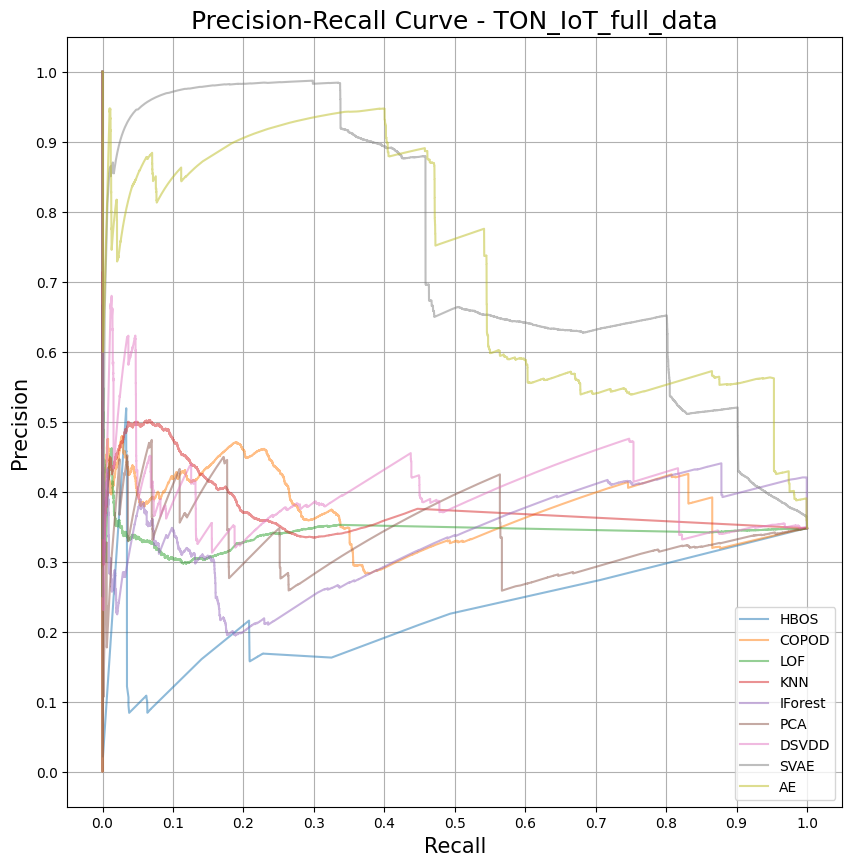

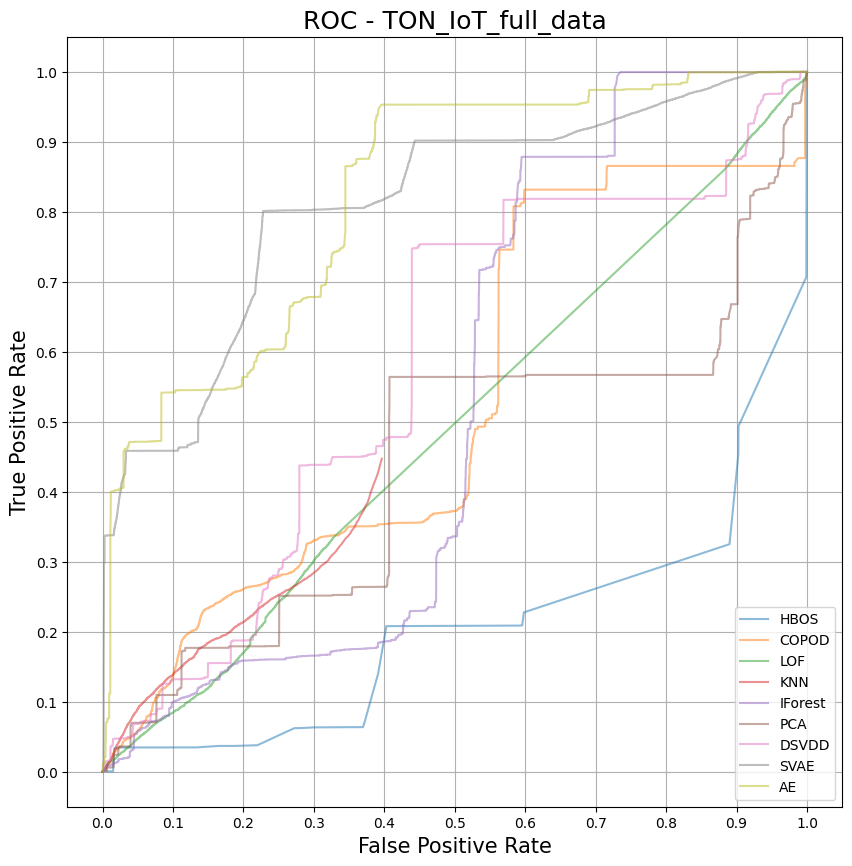

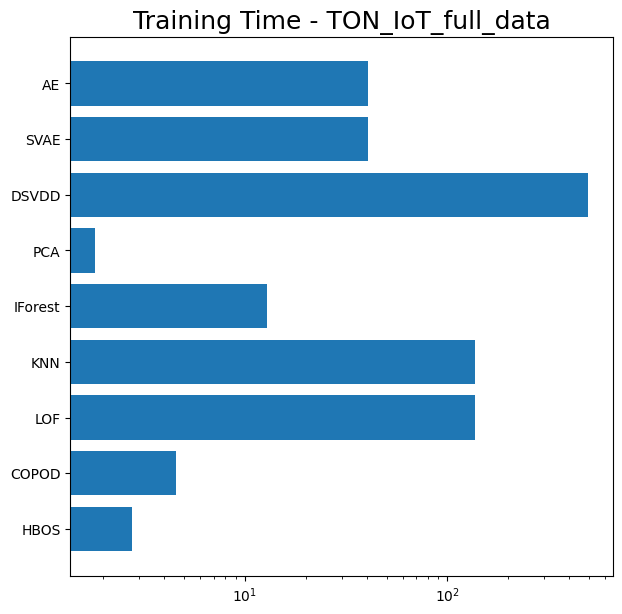

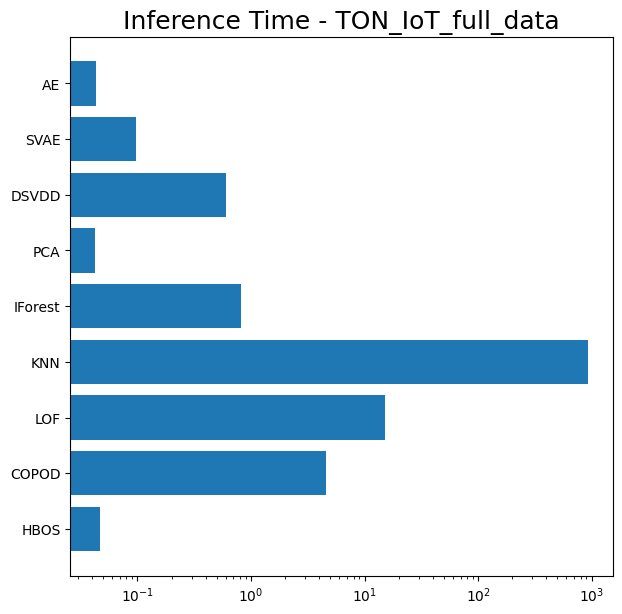

In [13]:
SAVE = False
if DATASET == 'medical_data' or DATASET == 'network_data' or DATASET == 'full_data':
    prefix = 'EHMS '
else:
    prefix = ''
visualize_curve(metrics=pr_dict, x_label="Recall", y_label="Precision", title="Precision-Recall Curve - "+prefix+DATASET, save=SAVE) # visualize PR
visualize_curve(metrics=roc_dict, x_label="False Positive Rate", y_label="True Positive Rate", title="ROC - " +prefix+DATASET, save=SAVE) # visualize ROC
#visualize_curve(metrics=mcc_dict, x_label="Thresholds", y_label="MCC", title="MCC-Threshold Curve - "+prefix+DATASET, save=SAVE) # visualize MCC
visualize_bar(train_time_dict, save=SAVE, title='Training Time - '+prefix+DATASET) # visualize training time
visualize_bar(inference_time_dict, save=SAVE, title='Inference Time - '+prefix+DATASET) # visualize inference time

In [ ]:
# AE train time
# medical: 56.3706 seconds. 2000 epochs. 
# TON full: 940.6104 seconds. 1000 epochs.
# iiot: 207.1402 seconds. 100 epochs.
# ECU IoHT: 40.4278 seconds. 1000 epochs.

In [ ]:
# metrics
""" 
precision, recall, _ = metrics.precision_recall_curve(y_true=y_test, probas_pred=y_pred)
fpr, tpr, _ = metrics.roc_curve(y_true=y_test, y_score=y_pred)
disp = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()
print(metrics.auc(recall, precision))
print(metrics.auc(fpr, tpr))

fig = plt.figure(figsize = (5, 5))
ax1 = fig.add_subplot(1,1,1) 
ax2 = fig.add_subplot(1,1,1)
ax1.grid()

ax1.plot(recall, precision)
ax2.plot(fpr, tpr)

ax2.set_xlabel('fpr', fontsize = 12)
ax2.set_ylabel('tpr', fontsize = 12) """

" \nprecision, recall, _ = metrics.precision_recall_curve(y_true=y_test, probas_pred=y_pred)\nfpr, tpr, _ = metrics.roc_curve(y_true=y_test, y_score=y_pred)\ndisp = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)\ndisp.plot()\nplt.show()\nprint(metrics.auc(recall, precision))\nprint(metrics.auc(fpr, tpr))\n\nfig = plt.figure(figsize = (5, 5))\nax1 = fig.add_subplot(1,1,1) \nax2 = fig.add_subplot(1,1,1)\nax1.grid()\n\nax1.plot(recall, precision)\nax2.plot(fpr, tpr)\n\nax2.set_xlabel('fpr', fontsize = 12)\nax2.set_ylabel('tpr', fontsize = 12) "

In [ ]:
a = []
a.append(np.array([0, 1, 1, 0, 1]))
a.append(np.array([0, 1, 1, 0, 1]))
functools.reduce(lambda a,b: a+b, a)/2

array([0., 1., 1., 0., 1.])

: 